# Problem Description: Burger's Equation

Governing equation $$u_t + uu_x = vu_{xx}, \quad x\in [-1,1],\quad t>0$$
where $ \frac{\nu=0.01}{\pi}$

Initial Condition: $$u(x,0) = -sin(\pi x)$$
Boundary Condition: $$u(-1,t)=u(1,t)=0$$


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def convert_np_to_tensor(array):
  if isinstance(array, np.ndarray):
    # Convert NumPy array to PyTorch tensor
    tensor = torch.from_numpy(array)
    return tensor.to(torch.float32)
  else:
    return array

In [4]:
d =  np.load("train_burgers.npz",allow_pickle=True)
branch_np, trunk_np, Y_np = d["branch"], d["trunk"], d["y"]
branch   = convert_np_to_tensor(branch_np)
trunk   = convert_np_to_tensor(trunk_np)
Y = convert_np_to_tensor(Y_np)

print(f'branch shape: {branch.shape}, type: {type(branch)}, dtype: {branch.dtype}')
print(f'trunk shape: {trunk.shape}, type: {type(trunk)}, dtype: {trunk.dtype}')
print(f'Y shape: {Y.shape}, type: {type(Y)}, dtype: {Y.dtype}')

branch shape: torch.Size([20, 5]), type: <class 'torch.Tensor'>, dtype: torch.float32
trunk shape: torch.Size([65536, 2]), type: <class 'torch.Tensor'>, dtype: torch.float32
Y shape: torch.Size([20, 65536]), type: <class 'torch.Tensor'>, dtype: torch.float32


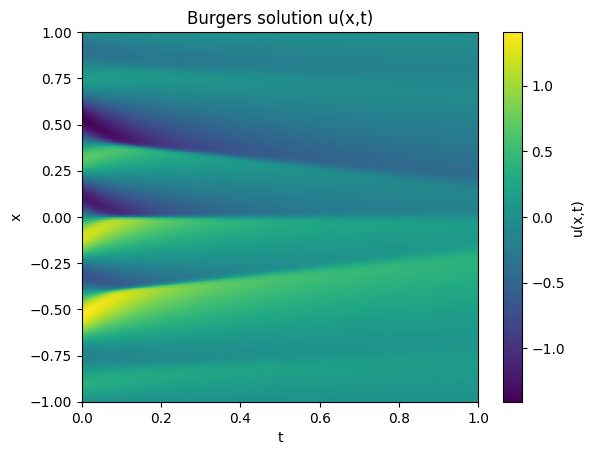

In [147]:
trunk_visual = d["trunk"]
Y_visual = d["y"]
idx = 11

# meshgrid 여부 확인
x_unique = np.unique(trunk_visual[:,0])
t_unique = np.unique(trunk_visual[:,1])
Nx, Nt = len(x_unique), len(t_unique)

u_xt = Y_visual[idx].reshape(Nx, Nt)

plt.figure()
plt.imshow(
    u_xt,
    origin="lower",
    aspect="auto",
    extent=[t_unique.min(), t_unique.max(),
            x_unique.min(), x_unique.max()]
)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label="u(x,t)")
plt.title("Burgers solution u(x,t)")
plt.savefig(f"DeepONet_Burgers_idx{idx}_data.png", dpi=300, bbox_inches="tight")
plt.show()


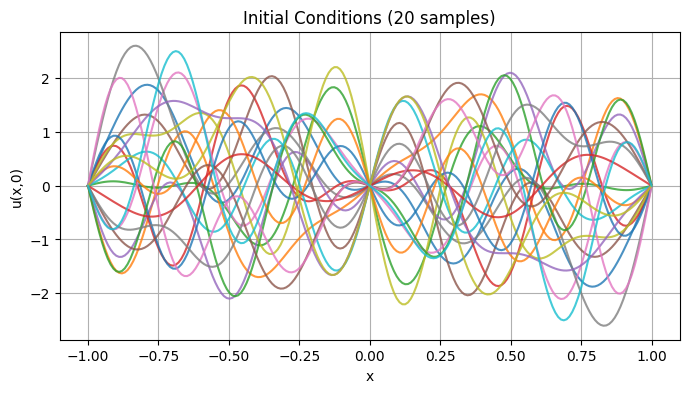

In [148]:
branch_visual = d["branch"]   # (n_samples, K)

# x grid for plotting ICs
x = np.linspace(-1, 1, 200)

plt.figure(figsize=(8, 4))

n_plot = 20  # 몇 개 IC를 겹쳐서 볼지

for i in range(n_plot):
    a = branch_visual[i]  # (K,)
    
    # reconstruct IC: u(x,0)
    u0 = np.zeros_like(x)
    for k, ak in enumerate(a, start=1):
        u0 += ak * np.sin(k * np.pi * x)
    u0 = -u0

    plt.plot(x, u0, alpha=0.8)

plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Conditions (20 samples)")
plt.grid(True)
plt.show()


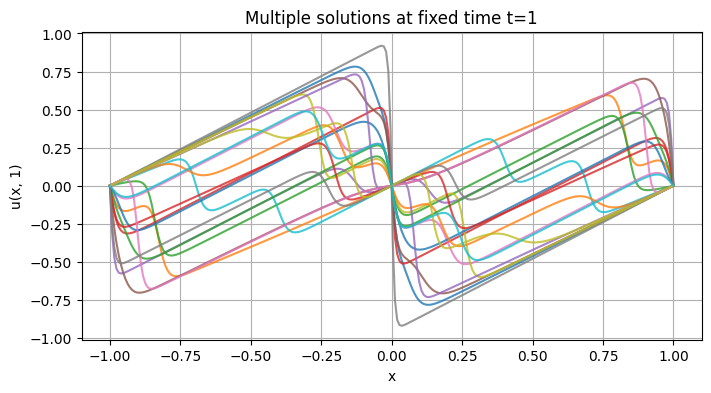

1.0


In [149]:
# find index closest to t=1
t_vals = np.unique(trunk_visual[:,1])
t_idx = np.argmin(np.abs(t_vals - 1))

Nx, Nt= len(np.unique(trunk_visual[:,0])), len(t_vals)

plt.figure(figsize=(8, 4))

for i in range(n_plot):
    u_xt = Y_visual[i].reshape(Nx, Nt)
    plt.plot(np.unique(trunk_visual[:,0]), u_xt[:, t_idx], alpha=0.8)

plt.xlabel("x")
plt.ylabel("u(x, 1)")
plt.title("Multiple solutions at fixed time t=1")
plt.grid(True)
plt.show()

print(t_vals[t_idx])

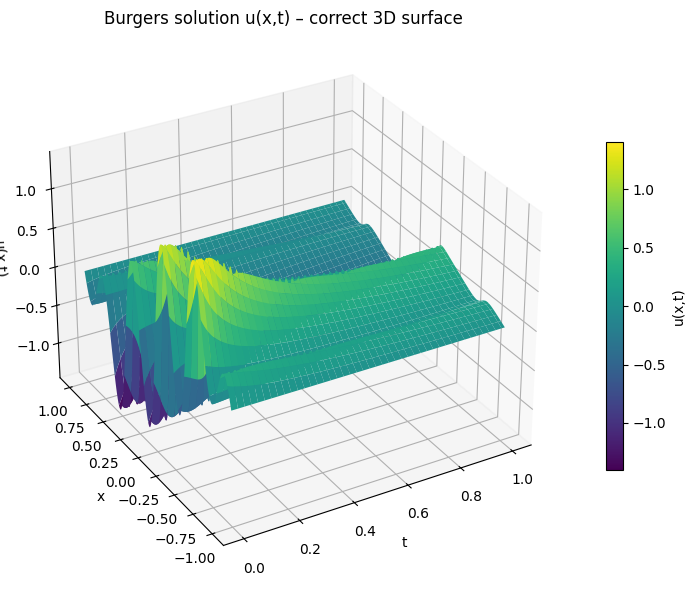

In [150]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
from matplotlib.colors import Normalize

trunk_visual = d["trunk"]
Y_visual = d["y"]
idx = 11

# infer grid
x_unique = np.unique(trunk_visual[:, 0])
t_unique = np.unique(trunk_visual[:, 1])
Nx, Nt = len(x_unique), len(t_unique)

u_xt = Y_visual[idx].reshape(Nx, Nt)

X, T = np.meshgrid(x_unique, t_unique, indexing="ij")

# 🔑 핵심: 컬러 정규화 직접 지정
norm = Normalize(vmin=u_xt.min(), vmax=u_xt.max())

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    T, X, u_xt,
    cmap=cm.viridis,
    norm=norm,
    linewidth=0,
    antialiased=True
)

# 시점 조정 (중요)
ax.view_init(elev=30, azim=-120)

ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_zlabel("u(x,t)")
ax.set_title("Burgers solution u(x,t) – correct 3D surface")

fig.colorbar(surf, ax=ax, shrink=0.6, label="u(x,t)")
plt.tight_layout()
plt.savefig(f"DeepONet_Burgers_idx{idx}_3d_data.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
class Datahandler(Dataset):
  def __init__(self, u_branch, y_trunk, guy):
    self.u_branch = u_branch
    self.y_trunk = y_trunk
    self.guy = guy

  def __len__(self):
    return len(self.guy)

  def __getitem__(self, index):
    return self.u_branch[index,:], self.y_trunk, self.guy[index,:]

In [6]:
dataset = Datahandler(branch, trunk, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 20, shuffle=True)

In [7]:
class Network(torch.nn.Module):
    def __init__(self, branch_dim, trunk_dim, width=64):
        super(Network, self).__init__()

        self.bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.branch = nn.Sequential(
            nn.Linear(branch_dim, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU()
        )

        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU(),
            nn.Linear(width, width), nn.ReLU()
        )
    
    def forward(self, branch, trunk):
        branch_out = self.branch(branch)
        trunk_out  = self.trunk(trunk)
        out = branch_out @ trunk_out.T + self.bias
        return out

def init_weights(m): 
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data) 
        nn.init.zeros_(m.bias)

In [8]:
model = Network(branch_dim=branch.shape[1], trunk_dim=trunk.shape[1], width=128)
model.apply(init_weights)

Network(
  (branch): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
  )
)

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_history = {'loss':[]}

In [10]:
n_epochs = 10000
for epoch in range(n_epochs):
  losses = []
  for branch_batch, _, Y_batch in dataloader: 
    optimizer.zero_grad()

    pred = model(branch_batch, trunk)
    loss = loss_fn(pred, Y_batch)

    loss.backward()

    losses.append(loss.item())

    optimizer.step()

  avg_loss = np.mean(losses)
  if epoch%1000 == 0:
    print(f'Epoch: {epoch}, Loss: {float(avg_loss): .2}')

Epoch: 0, Loss:  0.29
Epoch: 1000, Loss:  0.031
Epoch: 2000, Loss:  0.016
Epoch: 3000, Loss:  0.011
Epoch: 4000, Loss:  0.011
Epoch: 5000, Loss:  0.0067
Epoch: 6000, Loss:  0.0052
Epoch: 7000, Loss:  0.0046
Epoch: 8000, Loss:  0.0046
Epoch: 9000, Loss:  0.0042


In [ ]:
'''
loss_fn = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, history_size=10)
train_history = {'loss': []}
'''

In [ ]:
'''
n_epochs = 300  # L-BFGS는 한 epoch 내에서 많이 계산하므로 전체 epoch 수는 줄여도 됩니다.

for epoch in range(n_epochs):
    # L-BFGS는 미니배치보다는 전체 데이터(Full-batch)에서 가장 잘 작동합니다.
    # 여기서는 dataloader에서 데이터를 가져오는 구조를 유지하면서 적용합니다.
    
    for branch_batch, _, Y_batch in dataloader:
        
        # L-BFGS를 위한 closure 함수 정의
        def closure():
            optimizer.zero_grad()
            pred = model(branch_batch, trunk)
            loss = loss_fn(pred, Y_batch)
            loss.backward()
            return loss

        # optimizer.step에 closure를 전달하여 업데이트
        loss = optimizer.step(closure)
        
        # 기록을 위해 loss 값 저장
        train_history['loss'].append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item():.6f}')
'''

Epoch: 0, Loss: 0.032560
Epoch: 10, Loss: 0.031425
Epoch: 20, Loss: 0.030499
Epoch: 30, Loss: 0.029783
Epoch: 40, Loss: 0.028820
Epoch: 50, Loss: 0.028183
Epoch: 60, Loss: 0.027716
Epoch: 70, Loss: 0.027087
Epoch: 80, Loss: 0.026473
Epoch: 90, Loss: 0.025688
Epoch: 100, Loss: 0.024975
Epoch: 110, Loss: 0.024451
Epoch: 120, Loss: 0.024011
Epoch: 130, Loss: 0.023585
Epoch: 140, Loss: 0.023126
Epoch: 150, Loss: 0.022687
Epoch: 160, Loss: 0.022256
Epoch: 170, Loss: 0.021911
Epoch: 180, Loss: 0.021607
Epoch: 190, Loss: 0.021298
Epoch: 200, Loss: 0.020974
Epoch: 210, Loss: 0.020694
Epoch: 220, Loss: 0.020460
Epoch: 230, Loss: 0.020196
Epoch: 240, Loss: 0.019981
Epoch: 250, Loss: 0.019845
Epoch: 260, Loss: 0.019702
Epoch: 270, Loss: 0.019525
Epoch: 280, Loss: 0.019344
Epoch: 290, Loss: 0.019160


In [13]:
d =  np.load("test_burgers.npz",allow_pickle=True)
branch_test_np, trunk_test_np, Y_test_np = d["branch"], d["trunk"], d["y"]
branch_test = convert_np_to_tensor(branch_test_np)
trunk_test = convert_np_to_tensor(trunk_test_np)
Y_test = convert_np_to_tensor(Y_test_np)

print(f'branch_test shape: {branch_test.shape}, type: {type(branch_test)}, dtype: {branch_test.dtype}')
print(f'trunk_test shape: {trunk_test.shape}, type: {type(trunk_test)}, dtype: {trunk_test.dtype}')
print(f'Y_test shape: {Y_test.shape}, type: {type(Y_test)}, dtype: {Y_test.dtype}')

branch_test shape: torch.Size([20, 5]), type: <class 'torch.Tensor'>, dtype: torch.float32
trunk_test shape: torch.Size([65536, 2]), type: <class 'torch.Tensor'>, dtype: torch.float32
Y_test shape: torch.Size([20, 65536]), type: <class 'torch.Tensor'>, dtype: torch.float32


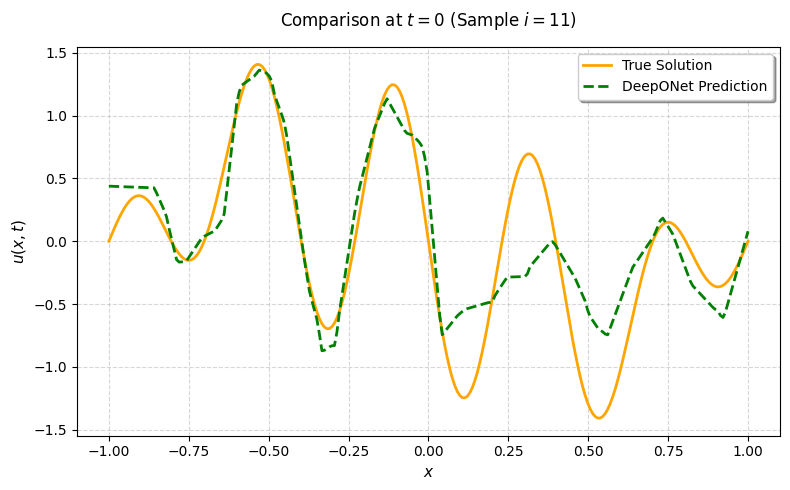

In [158]:
# 기초 예제 스타일 + 시각화 강화 버전
i = 11
t_interest = 0

# 1. 예측 (가장 간결하게)
u_pred = model(branch[i:i+1], trunk).detach().numpy().flatten()

# 2. 데이터 정리
x_vals = np.unique(trunk_np[:, 0])
t_vals = np.unique(trunk_np[:, 1])
t_idx = np.argmin(np.abs(t_vals - t_interest))

u_true = Y_np[i].reshape(len(x_vals), len(t_vals))
u_pred = u_pred.reshape(len(x_vals), len(t_vals))

plt.figure(figsize=(8, 5))
plt.plot(x_vals, u_true[:, t_idx], color='orange', linewidth=2, label='True Solution')
plt.plot(x_vals, u_pred[:, t_idx], color='green', linestyle='--', linewidth=2, label='DeepONet Prediction')
plt.title(f"Comparison at $t = {t_interest}$ (Sample $i = {i}$)", fontsize=12, pad=15)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$u(x, t)$", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=True, shadow=True, loc='best')
plt.tight_layout()
plt.savefig(f"DeepONet_Burgers_idx{idx}_t{t_interest}_pred.png", dpi=300, bbox_inches="tight")
plt.show()

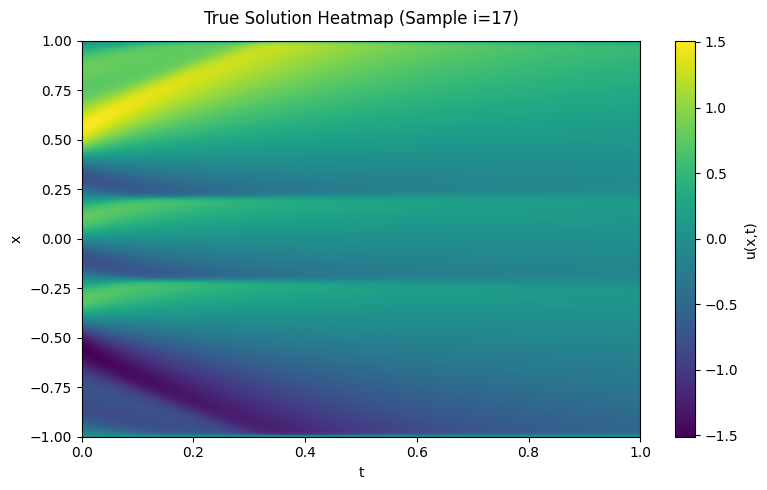

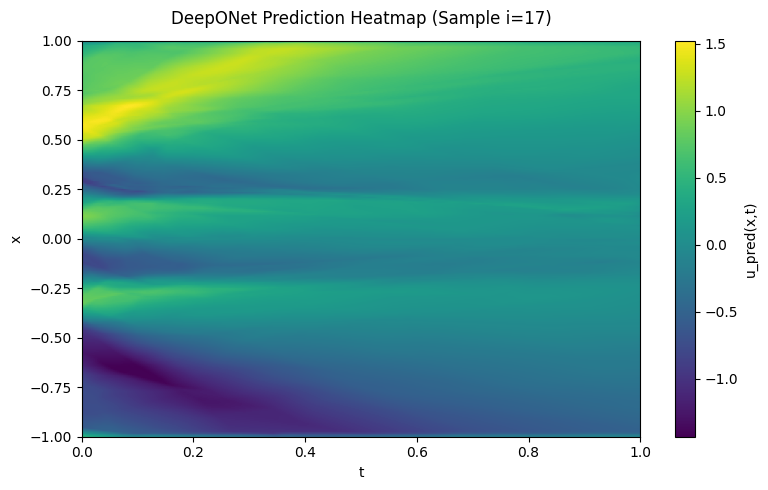

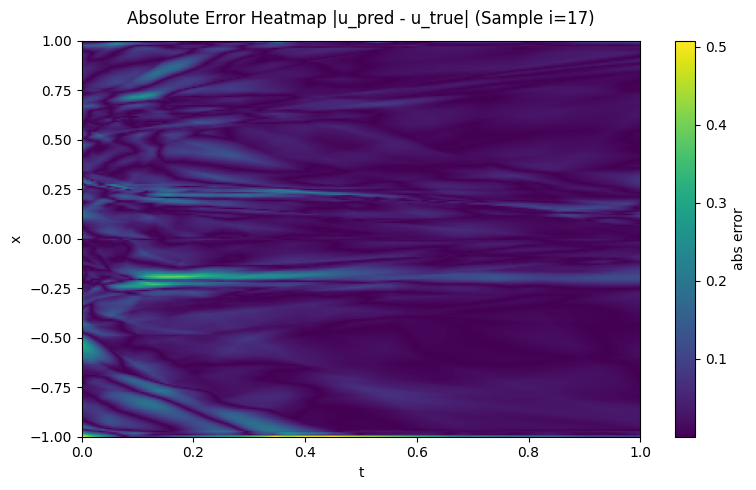

In [20]:
i = 17

# 1) 예측 (너 코드 스타일 유지)
u_pred = model(branch[i:i+1], trunk).detach().cpu().numpy().flatten()

# 2) 격자 정보
x_vals = np.unique(trunk_np[:, 0])
t_vals = np.unique(trunk_np[:, 1])
Nx, Nt = len(x_vals), len(t_vals)

# 3) True / Pred를 (Nx, Nt)로 reshape
u_true = Y_np[i].reshape(Nx, Nt)
u_pred = u_pred.reshape(Nx, Nt)

# -------------------------
# Heatmap: True
# -------------------------
plt.figure(figsize=(8, 5))
plt.imshow(
    u_true,
    origin="lower",
    aspect="auto",
    extent=[t_vals.min(), t_vals.max(), x_vals.min(), x_vals.max()]
)
plt.title(f"True Solution Heatmap (Sample i={i})", pad=12)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label="u(x,t)")
plt.tight_layout()
plt.savefig(f"DeepONet_Burgers_True Solution Heatmap (Sample i={i})_final.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------------
# Heatmap: Prediction
# -------------------------
plt.figure(figsize=(8, 5))
plt.imshow(
    u_pred,
    origin="lower",
    aspect="auto",
    extent=[t_vals.min(), t_vals.max(), x_vals.min(), x_vals.max()]
)
plt.title(f"DeepONet Prediction Heatmap (Sample i={i})", pad=12)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label="u_pred(x,t)")
plt.tight_layout()
plt.savefig(f"DeepONet_Burgers_Prediction Heatmap (Sample i={i})_final.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------------
# Heatmap: Absolute Error
# -------------------------
abs_err = np.abs(u_pred - u_true)

plt.figure(figsize=(8, 5))
plt.imshow(
    abs_err,
    origin="lower",
    aspect="auto",
    extent=[t_vals.min(), t_vals.max(), x_vals.min(), x_vals.max()]
)
plt.title(f"Absolute Error Heatmap |u_pred - u_true| (Sample i={i})", pad=12)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label="abs error")
plt.tight_layout()
plt.savefig(f"DeepONet_Burgers_Absolute Error Heatmap (Sample i={i})_final.png", dpi=300, bbox_inches="tight")
plt.show()


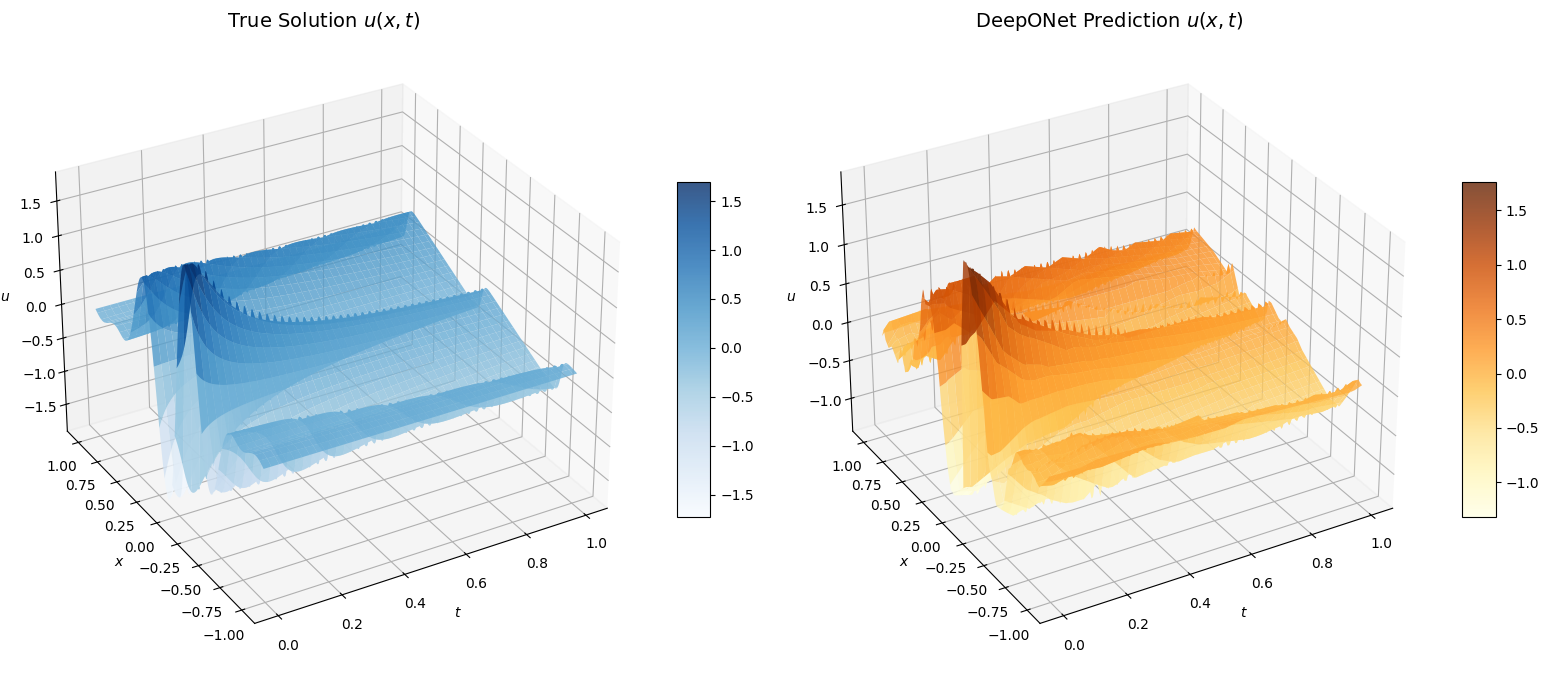

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 1. 예측값 계산 (CPU 기준 간결하게)
i = 2
u_pred_raw = model(branch[i:i+1], trunk).detach().numpy().flatten()

# 2. 그리드 데이터 준비
x_unique = np.unique(trunk_np[:, 0])
t_unique = np.unique(trunk_np[:, 1])
Nx, Nt = len(x_unique), len(t_unique)

u_true_grid = Y_np[i].reshape(Nx, Nt)
u_pred_grid = u_pred_raw.reshape(Nx, Nt)
X, T = np.meshgrid(x_unique, t_unique, indexing="ij")

# 3. 3D 시각화 (True vs Prediction)
fig = plt.figure(figsize=(16, 7))

# --- 좌측: True Solution ---
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(T, X, u_true_grid, cmap=cm.Blues, linewidth=0, antialiased=True, alpha=0.8)
ax1.set_title(r"$\text{True Solution } u(x,t)$", fontsize=14)
ax1.set_xlabel("$t$"); ax1.set_ylabel("$x$"); ax1.set_zlabel("$u$")
ax1.view_init(elev=30, azim=-120)

# --- 우측: DeepONet Prediction ---
ax2 = fig.add_subplot(122, projection='3d')
# 예측값은 오렌지색 계열(YlOrBr)로 차별화
surf2 = ax2.plot_surface(T, X, u_pred_grid, cmap=cm.YlOrBr, linewidth=0, antialiased=True, alpha=0.8)
ax2.set_title(r"$\text{DeepONet Prediction } u(x,t)$", fontsize=14)
ax2.set_xlabel("$t$"); ax2.set_ylabel("$x$"); ax2.set_zlabel("$u$")
ax2.view_init(elev=30, azim=-120)

# 컬러바 추가
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.savefig(f"DeepONet_Burgers_idx{idx}_3d_true_pred_epoch10000.png", dpi=300, bbox_inches="tight")
plt.show()

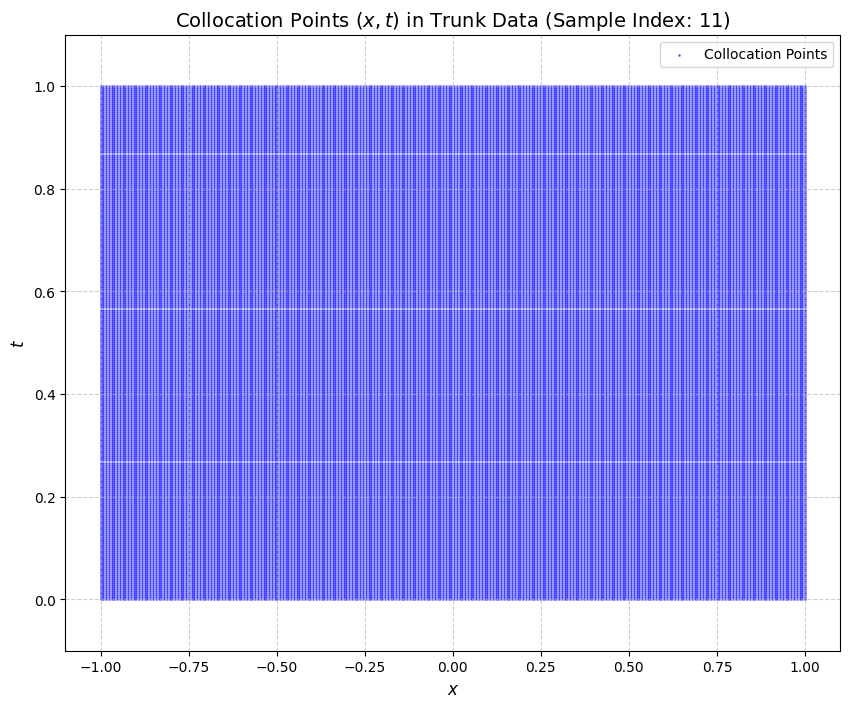

Total number of points: 65536


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드
data = np.load("test_burgers.npz")
trunk_col = data['trunk']  # shape: (Nx * Nt, 2)
# trunk[:, 0]은 x 좌표, trunk[:, 1]은 t 좌표를 나타냅니다.

# 2. n_samples = 11에 해당하는 좌표 추출
# 이 데이터셋 구조에서 trunk 포인트는 모든 샘플에 대해 공통입니다.
x_coords = trunk_col[:, 0]
t_coords = trunk_col[:, 1]

# 3. Scatter Plot 그리기
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, t_coords, s=1, c='blue', alpha=0.5, label='Collocation Points')

# 그래프 스타일 설정
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$t$', fontsize=12)
plt.title('Collocation Points $(x, t)$ in Trunk Data (Sample Index: 11)', fontsize=14)
plt.xlim([-1.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 결과 저장 및 출력
plt.show()
print(f"Total number of points: {len(x_coords)}")